# Train a Production Model

In this tutorial, you will use the existing hyperparameters that yielded the best performing model in the previous **Tutorial 6, "Compare models to select the best hyperparameters"** to train a production model on the full dataset, rather than just the training subset from a **scaffold split**. Training a model on the full dataset is one approach for creating a production model. Another approach, not demonstrated in this tutorial, is to combine the training and validation subsets for training and evaluating with the test subset. **[K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_\(statistics\)#k-fold_cross-validation)** makes use of this approach. The production model could be shared with other researchers to predict on new data. 

We will use the functions below to retrain the best original model for production and compare the production model with the original model. **We use the word "retrain" here to describe 
creating a new model based on the same hyperparameters; retraining doesn't replace the existing model.** 

We will use functions covered in **Tutorial 3, "Train a Simple Regression Model"** to evaluate the original and production models on an external test dataset.

We will focus on these functions in this tutorial:

- [create_prediction_pipeline_from_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.model_pipeline.create_prediction_pipeline_from_file)
- [train_model_from_tar](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model_from_tar)

>**Notes:**
>
>*1. `train_model_from_tar` and other functions in the `model_retrain` module can be used to update a previously trained model when there is a new **[AMPL](https://github.com/ATOMScience-org/AMPL)** release that is not compatible with previous versions. This is not covered in this tutorial.*
>
>*2. When a model input dataset is updated with additional data, the model should be trained from scratch with a new hyperparameter optimization run; *then* a new version of the production model can be generated*. 

## Import Packages

In [1]:
import pandas as pd
import os
from atomsci.ddm.utils import model_retrain as mr
from atomsci.ddm.utils import model_version_utils as mv
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-07-19 14:50:57.281438: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 14:50:57.282935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 14:50:57.306846: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 14:50:57.307874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 14:50:57.893201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Start From Saved Best Model

We're using the best performing model by validation set $R^2$ from **Tutorial 6, "Compare models to select the best hyperparameters"**. This was a **random forest** model. The model path, validation set $R^2$
and RF-specific parameters were as follows:

|Parameter|Value|
|---|---|
|Model Path|dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz|
|Best valid r2 score| 0.5595899501867392|
|Model Parameters|{"rf_estimators": 129, "rf_max_depth": 32, "rf_max_features": 95}|

When you load a previously trained model, either for running predictions or retraining, the parameters used to train the model are obtained from a file called 'model_metadata.json' that is stored
in the model's .tar.gz file. The `production` parameter controls whether the data is split into training, validation and test sets. During normal training and hyperparameter optimization, the 
`production` parameter is set False; setting it True causes all splitting related parameters to be ignored. When you call `train_model_from_tar` with the `production` argument set True, the code
overrides the `production` parameter in the model parameters to set it True, so that all the data is used for training.

In the following code, `create_prediction_pipeline_from_file` is used to reload the original best model. We then verify that it was trained with `production` set to `False`. 

We also check the **[AMPL](https://github.com/ATOMScience-org/AMPL)** version to make sure the saved model was trained with a version of **[AMPL](https://github.com/ATOMScience-org/AMPL)** that is compatible with the installed version. The versions must be compatible in order to be used by `create_prediction_pipeline_from_file`, which we will be calling later to run predictions from the saved model.

In [2]:
#Tutorial 7 RF saved model_path
best_model_path='dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz'

#get installed AMPL version
print("installed AMPL version: " + str(mv.get_ampl_version()))

#get AMPL model version
print("best model AMPL version: " + str(mv.get_ampl_version_from_model(best_model_path)))

# check versions are compatible
assert(mv.check_version_compatible(best_model_path))

#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=best_model_path, model_type='best_model', featurization=None, verbose=False)

#show production is false
print("orig_params.production: " + str(best_model_pipe.orig_params.production))

INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz version = "1.6", AMPL version = "1.6"
INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz version = "1.6", AM

installed AMPL version: 1.6.1
best model AMPL version: 1.6.1
['/tmp/tmpeut4a7ad/best_model/checkpoint1.pt']
/tmp/tmpeut4a7ad/best_model/checkpoint1.pt
orig_params.production: False


## Retrain Best Model as Production Model

Setting the `production` argument for `train_model_from_tar` to `True` will set `production=True` in the model params. If the `production` argument for `train_model_from_tar` is `False`, the model will be retrained without changing any parameters. Note the production model's model parameter `production` is set to `True`.

In [3]:
odir='dataset/final_models'

production_model = mr.train_model_from_tar(input=best_model_path, output=odir, production=True)

#check for parameters
print("production_model.params.production: " + str(production_model.params.production))
print("production_model.params.model_tarball_path: " + str(production_model.params.model_tarball_path))

print("production model AMPL version: " + str(mv.get_ampl_version_from_model(production_model.params.model_tarball_path)))

/opt/atomsci-env/lib/python3.8/site-packages/deepchem/data/datasets.py:473: RuntimeWarning: overflow encountered in multiply
  X_m2 += dx * (X - X_means)
/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/final_data_curated_model_7ed1d224-6719-43fb-9a12-d6d22643d8f3.tar.gz, 1.6.1


['dataset/final_models/final_data_curated/NN_computed_descriptors_scaffold_regression/7ed1d224-6719-43fb-9a12-d6d22643d8f3/model/checkpoint1.pt', 'dataset/final_models/final_data_curated/NN_computed_descriptors_scaffold_regression/7ed1d224-6719-43fb-9a12-d6d22643d8f3/model/checkpoint2.pt', 'dataset/final_models/final_data_curated/NN_computed_descriptors_scaffold_regression/7ed1d224-6719-43fb-9a12-d6d22643d8f3/model/checkpoint3.pt', 'dataset/final_models/final_data_curated/NN_computed_descriptors_scaffold_regression/7ed1d224-6719-43fb-9a12-d6d22643d8f3/model/checkpoint4.pt', 'dataset/final_models/final_data_curated/NN_computed_descriptors_scaffold_regression/7ed1d224-6719-43fb-9a12-d6d22643d8f3/model/checkpoint5.pt']
dataset/final_models/final_data_curated/NN_computed_descriptors_scaffold_regression/7ed1d224-6719-43fb-9a12-d6d22643d8f3/model/checkpoint1.pt
production_model.params.production: True
production_model.params.model_tarball_path: dataset/final_models/final_data_curated_model_7

## Compare Performance on a Separate External Test Dataset

Here we will apply **Tutorial 4, "Application of a Trained Model"**'s steps to run predictions with the original best model and the production model, using an independent dataset of 
compounds that are structurally different (with Tanimoto distance > 0.4) from all compounds in the production dataset. We use this approach
to compare the performance of the two models. Since the production model is trained on all data, including the test subset, the original 
test subset **should not** be used to evaluate its performance.

First we'll load the external test dataset, which we've already featurized with **[RDKit](https://github.com/rdkit/rdkit)** descriptors:

In [4]:
train_file_path = 'dataset/final_production_train.csv'
train_data = pd.read_csv(train_file_path)
train_data.head()

,smiles,Y,compound_id,base_rdkit_smiles
0,CN1C2CCC(C)(C)C1CC(OC(=O)C(O)(c1cccs1)c1cccs1)C2,-2.535464,18301,CN1C2CCC(C)(C)C1CC(OC(=O)C(O)(c1cccs1)c1cccs1)C2
1,CN1CCCC(CN2c3ccccc3Sc3ccccc32)C1,-2.492014,18281,CN1CCCC(CN2c3ccccc3Sc3ccccc32)C1
2,C=CC(C)CCCC(C)(C)O,-1.637570,12420,C=CC(C)CCCC(C)(C)O
3,C=CC(=O)Nc1ccc(O)cc1,-2.244000,5037,C=CC(=O)Nc1ccc(O)cc1
4,NCCNCCNCCNCCNCCN,-2.162000,4517,NCCNCCNCCNCCNCCN


In [5]:
test_file_path = 'dataset/final_production_test.csv'
test_data = pd.read_csv(test_file_path)
test_data.head()

,smiles,Y,compound_id,base_rdkit_smiles
0,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3(F...,-2.625820,13255,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3(F...
1,COP(=O)(OC)SC,-4.017000,2652,COP(=O)(OC)SC
2,Cc1cccc2ncc(C(=O)NC(C)C)c(=O)n12,-2.991726,14973,Cc1cccc2ncc(C(=O)NC(C)C)c(=O)n12
3,CC(=O)N(C)C(=O)Oc1cccc(C(C)(C)C)c1,-2.397000,2065,CC(=O)N(C)C(=O)Oc1cccc(C(C)(C)C)c1
4,CCCCCNC(=O)c1cnc2cccc(C)n2c1=O,-3.038757,14975,CCCCCNC(=O)c1cnc2cccc(C)n2c1=O


We now predict $pK_i$ values with the original best model:

In [6]:
id_col = 'compound_id'
smiles_col = 'base_rdkit_smiles'
response_col = 'Y'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
# show most important columns
best_pred_df[['compound_id', 'base_rdkit_smiles', 'Y', 'Y_actual', 'Y_pred', 'Y_std']].head()

Standardizing SMILES strings for 1445 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/final_models/best_models/best_regression_final_data_curated_model_NN_rdkit_raw_a0ac4513-a33a-4a39-a9f7-113d9b852864.tar.gz version = "1.6", AMPL version = "1.6"


['/tmp/tmpu5v8manc/best_model/checkpoint1.pt']
/tmp/tmpu5v8manc/best_model/checkpoint1.pt


/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


,compound_id,base_rdkit_smiles,Y,Y_actual,Y_pred,Y_std
0,13255,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3(F...,-2.625820,-2.625820,-2.178141,0.665505
1,2652,COP(=O)(OC)SC,-4.017000,-4.017000,-3.065135,0.858477
2,14973,Cc1cccc2ncc(C(=O)NC(C)C)c(=O)n12,-2.991726,-2.991726,-2.633750,0.525636
3,2065,CC(=O)N(C)C(=O)Oc1cccc(C(C)(C)C)c1,-2.397000,-2.397000,-2.152318,0.486436
4,14975,CCCCCNC(=O)c1cnc2cccc(C)n2c1=O,-3.038757,-3.038757,-2.715088,0.525861


Now we'll run predictions on the same dataset with the production model:

In [10]:
prod_pred_train_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = train_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
# show most important columns
prod_pred_train_df[['compound_id', 'base_rdkit_smiles', 'Y', 'Y_actual', 'Y_pred', 'Y_std']].head()

Standardizing SMILES strings for 13000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/final_data_curated_model_7ed1d224-6719-43fb-9a12-d6d22643d8f3.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/final_models/final_data_curated_model_7ed1d224-6719-43fb-9a12-d6d22643d8f3.tar.gz version = "1.6", AMPL version = "1.6"


['/tmp/tmp0y_n2z23/best_model/checkpoint1.pt']
/tmp/tmp0y_n2z23/best_model/checkpoint1.pt


/opt/atomsci-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1774: RuntimeWarning: overflow encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/opt/atomsci-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1774: RuntimeWarning: invalid value encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


,compound_id,base_rdkit_smiles,Y,Y_actual,Y_pred,Y_std
0,18301,CN1C2CCC(C)(C)C1CC(OC(=O)C(O)(c1cccs1)c1cccs1)C2,-2.535464,-2.535464,-2.665365,0.919219
1,18281,CN1CCCC(CN2c3ccccc3Sc3ccccc32)C1,-2.492014,-2.492014,-2.721608,0.471832
2,12420,C=CC(C)CCCC(C)(C)O,-1.637570,-1.637570,-1.716474,0.469640
3,5037,C=CC(=O)Nc1ccc(O)cc1,-2.244000,-2.244000,-2.185090,0.745426
4,4517,NCCNCCNCCNCCNCCN,-2.162000,-2.162000,-2.540117,0.821807


In [7]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
# show most important columns
prod_pred_df[['compound_id', 'base_rdkit_smiles', 'Y', 'Y_actual', 'Y_pred', 'Y_std']].head()

Standardizing SMILES strings for 1445 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/final_models/final_data_curated_model_7ed1d224-6719-43fb-9a12-d6d22643d8f3.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/final_models/final_data_curated_model_7ed1d224-6719-43fb-9a12-d6d22643d8f3.tar.gz version = "1.6", AMPL version = "1.6"


['/tmp/tmpul3mpra5/best_model/checkpoint1.pt']
/tmp/tmpul3mpra5/best_model/checkpoint1.pt


/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


,compound_id,base_rdkit_smiles,Y,Y_actual,Y_pred,Y_std
0,13255,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3(F...,-2.625820,-2.625820,-2.178141,0.665505
1,2652,COP(=O)(OC)SC,-4.017000,-4.017000,-3.065135,0.858477
2,14973,Cc1cccc2ncc(C(=O)NC(C)C)c(=O)n12,-2.991726,-2.991726,-2.633750,0.525636
3,2065,CC(=O)N(C)C(=O)Oc1cccc(C(C)(C)C)c1,-2.397000,-2.397000,-2.152318,0.486436
4,14975,CCCCCNC(=O)c1cnc2cccc(C)n2c1=O,-3.038757,-3.038757,-2.715088,0.525861


To compare the performance of the production model with the original best model, we'll compute the $R^2$ scores for the predictions
from each model and then plot the predicted vs actual values:

In [21]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

def calculate_metrics(y_true, y_pred):
    r2 = np.round(r2_score(y_true, y_pred), 6)
    rho, p_value = spearmanr(y_true, y_pred)
    rho = np.round(rho, 6)
    mse = np.round(mean_squared_error(y_true, y_pred), 6)
    mae = np.round(mean_absolute_error(y_true, y_pred), 6)
    return r2, rho, p_value, mse, mae

def print_metrics(name, r2, rho, p_value, mse, mae):
    print(f"\n{name} Metrics:")
    print(f"{'R-squared:':<20} {r2:.6f}")
    print(f"{'Spearman rho:':<20} {rho:.6f}")
    print(f"{'p-value:':<20} {p_value:.6e}")  # Using scientific notation for p-value
    print(f"{'MSE:':<20} {mse:.6f}")
    print(f"{'MAE:':<20} {mae:.6f}")

# Calculate metrics
train_metrics = calculate_metrics(prod_pred_train_df.Y_actual.values, prod_pred_train_df.Y_pred.values)
best_metrics = calculate_metrics(best_pred_df.Y_actual.values, best_pred_df.Y_pred.values)
prod_metrics = calculate_metrics(prod_pred_df.Y_actual.values, prod_pred_df.Y_pred.values)

# Print metrics
print_metrics("Production Model Train", *train_metrics)
print_metrics("Prelim Model Test", *best_metrics)
print_metrics("Production Model Test", *prod_metrics)


Production Model Train Metrics:
R-squared:           0.621863
Spearman rho:        0.748443
p-value:             0.000000e+00
MSE:                 0.371444
MAE:                 0.445715

Prelim Model Test Metrics:
R-squared:           0.611185
Spearman rho:        0.767840
p-value:             2.413400e-281
MSE:                 0.392849
MAE:                 0.449313

Production Model Test Metrics:
R-squared:           0.674461
Spearman rho:        0.772177
p-value:             1.732890e-286
MSE:                 0.328917
MAE:                 0.427146


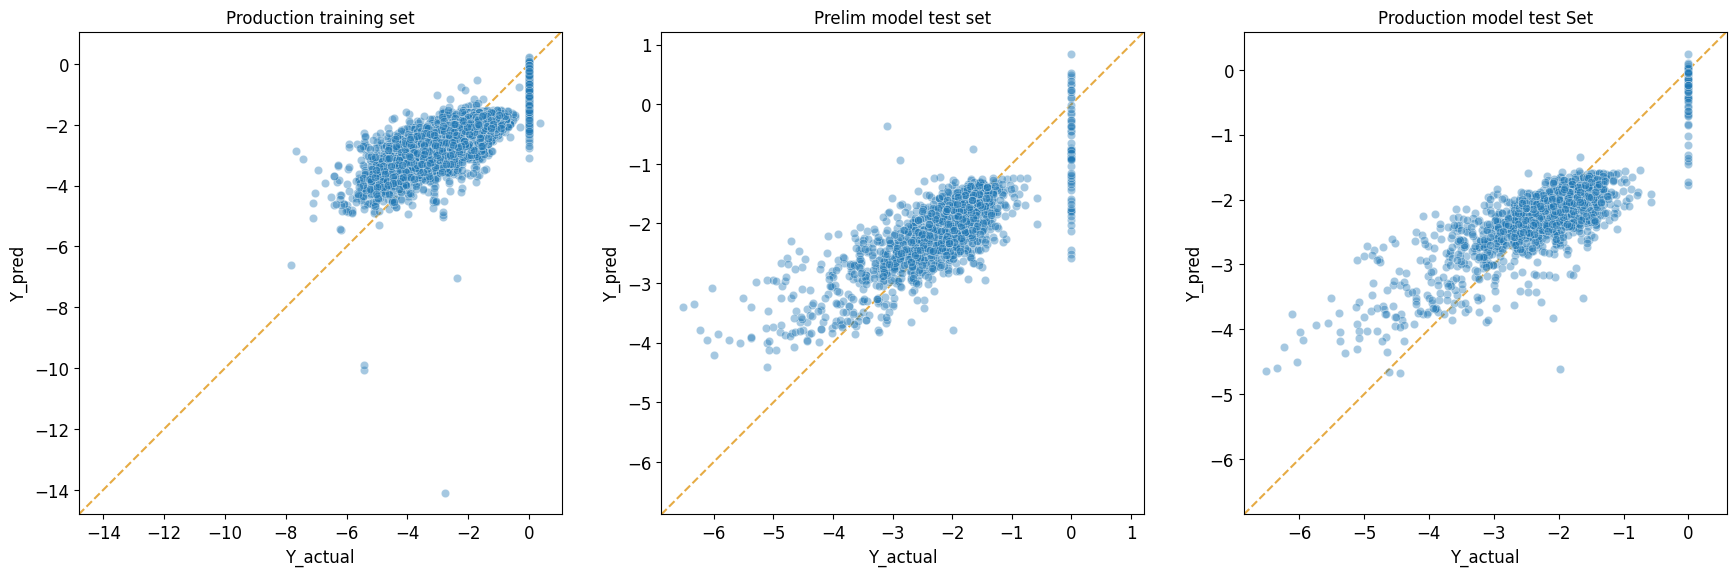

In [19]:
# Create the visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pp.plot_pred_vs_actual_from_df(prod_pred_train_df, actual_col='Y_actual', pred_col='Y_pred', 
    label=f"Training set, $R^2$ = {train_r2:.3f}, ρ = {train_rho:.3f}", ax=ax[0])

pp.plot_pred_vs_actual_from_df(best_pred_df, actual_col='Y_actual', pred_col='Y_pred', 
    label=f"Best model test, $R^2$ = {best_r2:.3f}, ρ = {best_rho:.3f}", ax=ax[1])

pp.plot_pred_vs_actual_from_df(prod_pred_df, actual_col='Y_actual', pred_col='Y_pred', 
    label=f"Production model test, $R^2$ = {prod_r2:.3f}, ρ = {prod_rho:.3f}", ax=ax[2])

# Add titles to subplots
ax[0].set_title("Production training set")
ax[1].set_title("Prelim model test set")
ax[2].set_title("Production model test Set")

# Adjust layout and display
fig.tight_layout(pad=3.0)
plt.show()

Although neither model has a great $R^2$ score, the production model *does* perform better, with $R^2$ = 0.267 vs 0.157 for the original best model.
Also, the points in the production model plot are slightly more concentrated along the diagonal. A possible explanation for the
mediocre performance is that the external dataset compounds were filtered so that none have Tanimoto distance  < 0.4 to any 
compound in the original model dataset, so that the test set compounds are outside of the 
**[applicability domain](https://en.wikipedia.org/wiki/Applicability_domain)** of both models.
We expect that the models' performance would improve on a dataset filtered with a smaller **[Tanimoto distance](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance)**  threshold.

Developing models that generalize well to diverse sets of compounds (i.e., that have a broader applicability domain) is one of the major
challenges in machine learning for chemistry. Training a **production model** is one approach to this problem. To do better we may need to explore
other model types or methods of featurizing molecules, with additional rounds of **hyperparameter optimization**.

## Other Functions With Production Parameters
A boolean `production` parameter is available in these other functions in the **[AMPL](https://github.com/ATOMScience-org/AMPL)** `model_retrain` module. 
If `production` is set to True, the model will be trained in 
production mode, using the entire dataset for training. Note that for **neural network models**, the model will be trained for the number of epochs
corresponding to the best epoch from the original model training run.
- [train_model](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model)
- [train_models_from_dataset_keys](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_models_from_dataset_keys)

In **Tutorial 8, "Visualizations of Model Performances"**, we'll explore a wide range of methods for visualizing and evaluating the performance of **[AMPL](https://github.com/ATOMScience-org/AMPL)** models.

If you have specific feedback about a tutorial, please complete the **[AMPL Tutorial Evaluation](https://forms.gle/pa9sHj4MHbS5zG7A6)**.